# Energy Data Parser

### Scope for *next* notebook
- outliers
- trend analysis for bad points
- interpolate/resample for missing cells
- ???

In [5]:
# Preliminary setup
import pandas as pd
import zipfile
import os

In [6]:
df = pd.read_pickle('alldata.pickle')

In [17]:
# Look through Lag Plot for each column for patterns
import numpy
from pandas.plotting import lag_plot 
import matplotlib.pyplot as plt

# Remove rows with '?'
df1 = df.replace({'?': numpy.nan}).dropna().astype(float)

# Set plot style
plt.style.use('ggplot')

# Lag plot for each column
for i in range(0, len(df.columns)-1):
    
    x = df1.iloc[:,i] # set column
    title = df.columns[i] + " lag 1 plot" # set title
    
    #fig = plt.figure()
    #fig.suptitle(title)
    #ax = plt.axes()
    #lag_plot(x)
    
    #fig = plt.figure()
    #fig.suptitle(title)
    #ax = plt.axes()
    #ax.plot(x[0:df1.shape[0]-1], x[1:df1.shape[0]], 'bo', markersize=1)

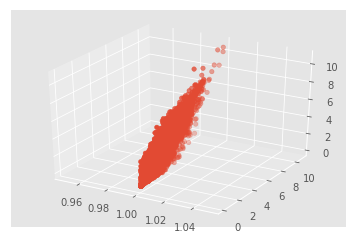

In [18]:
# Lag Lag Plots
from mpl_toolkits.mplot3d import Axes3D

x = df1.iloc[:,0]

a = pd.DataFrame({'A' : numpy.array([1] * df1.shape[0],dtype='int32'),
                 'B' : x,
                 'C' : x.shift(1)})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(a['A'], a['B'], a['C'])
#fig.suptitle(title)